In [43]:
pip install xgboost


     -------------------------------------- 124.9/124.9 MB 7.0 MB/s eta 0:00:00


In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBClassifier

from datetime import datetime


In [59]:
#reading dataset
df = pd.read_csv('Credit card transaction.csv')
df = df.drop(df.columns[0], axis=1)
df = df.dropna()
df

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,01/01/2019 00:00,2.703186e+15,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-81.1781,3495,"Psychologist, counselling",09/03/1988,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
2,01/01/2019 00:00,3.885949e+13,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,-112.2620,4154,Nature conservation officer,19/01/1962,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
4,01/01/2019 00:03,3.755342e+14,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,-79.4629,99,Dance movement psychotherapist,28/03/1986,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0
5,01/01/2019 00:04,4.767265e+15,"fraud_Stroman, Hudson and Erdman",gas_transport,94.63,Jennifer,Conner,F,4655 David Island,Dublin,...,-75.2045,2158,Transport planner,19/06/1961,189a841a0a8ba03058526bcfe566aab5,1325376248,40.653382,-76.152667,0,17972.0
7,01/01/2019 00:05,6.011361e+15,fraud_Corwin-Collins,gas_transport,71.65,Steven,Williams,M,231 Flores Pass Suite 720,Edinburg,...,-78.6003,6018,"Designer, multimedia",21/08/1947,6d294ed2cc447d2c71c7171a3d54967c,1325376308,38.948089,-78.540296,0,22644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49994,29/01/2019 22:44,4.861310e+18,fraud_Reichel LLC,personal_care,40.92,Ashley,Cruz,F,65417 Walsh Radial Suite 691,Saint Amant,...,-90.8435,10076,"Surveyor, rural practice",16/12/1977,b1f362f51cac2088901903ebdf87edf5,1327877090,30.347611,-90.878918,0,70733.0
49995,29/01/2019 22:44,4.708992e+15,fraud_Weber and Sons,food_dining,12.48,Jared,Walters,M,3326 Hannah Fords,Cord,...,-91.3375,376,"Designer, ceramics/pottery",08/09/1938,acb3cb45b9d3e07dbdb8d68f00d0ab10,1327877095,35.609706,-90.830032,0,72479.0
49996,29/01/2019 22:45,4.265776e+15,fraud_Terry Ltd,home,47.25,Christine,Best,F,68248 Deanna Land,Enola,...,-92.2123,969,"Physicist, medical",05/01/1954,f5f18968b900b90e1dd859e459c8528f,1327877158,35.214746,-92.173336,0,72047.0
49997,29/01/2019 22:46,6.592244e+15,fraud_Ratke and Sons,health_fitness,20.71,Philip,Hart,M,97405 Vazquez Plains,Montgomery,...,-86.2715,214703,"Chemist, analytical",07/10/1994,d4440aef1d5ce9a22df1ce1285cdeb1c,1327877181,32.925408,-85.396591,0,36862.0


In [60]:
class ToDenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.toarray() if hasattr(X, 'toarray') else X


In [61]:
df['dob'] = pd.to_datetime(df['dob'], format='%d/%m/%Y', errors='coerce')
current_date = datetime.now()
df['age'] = df['dob'].apply(lambda x: current_date.year - x.year - ((current_date.month, current_date.day) < (x.month, x.day)) if pd.notnull(x) else None)
df = df.drop(columns=['dob'])

In [66]:
#selecting features and is_fraud as tarrget

X = df.drop(columns=['is_fraud'])
y = df['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])


In [67]:
#assigning the k value
feature_selector = SelectKBest(score_func=f_classif, k=10) 

In [75]:
#models we are using
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Classifier': SVC(probability=True, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(random_state=42)
}



In [76]:
#storing the model performance
model_performance = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selection', feature_selector),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    
    model_performance[name] = {
        'Accuracy': accuracy,
        'F1-Score': f1,
        'AUC-ROC': auc
    }

In [77]:
#selecting the best model to use
best_model_name = max(model_performance, key=lambda x: model_performance[x]['AUC-ROC'] if model_performance[x]['AUC-ROC'] is not None else 0)
best_model = models[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Performance: {model_performance[best_model_name]}")

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selector),
    ('classifier', best_model)
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else None


Best Model: XGBoost
Performance: {'Accuracy': 0.9914974019839395, 'F1-Score': 0.1, 'AUC-ROC': 0.9483647169644998}


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     12593
           1       0.55      0.06      0.10       109

    accuracy                           0.99     12702
   macro avg       0.77      0.53      0.55     12702
weighted avg       0.99      0.99      0.99     12702



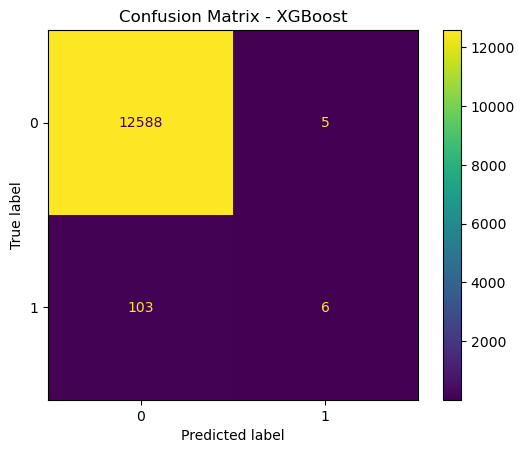

In [78]:
#CLASSIFICATION REPORT AND CONFUSION MATRIX
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()


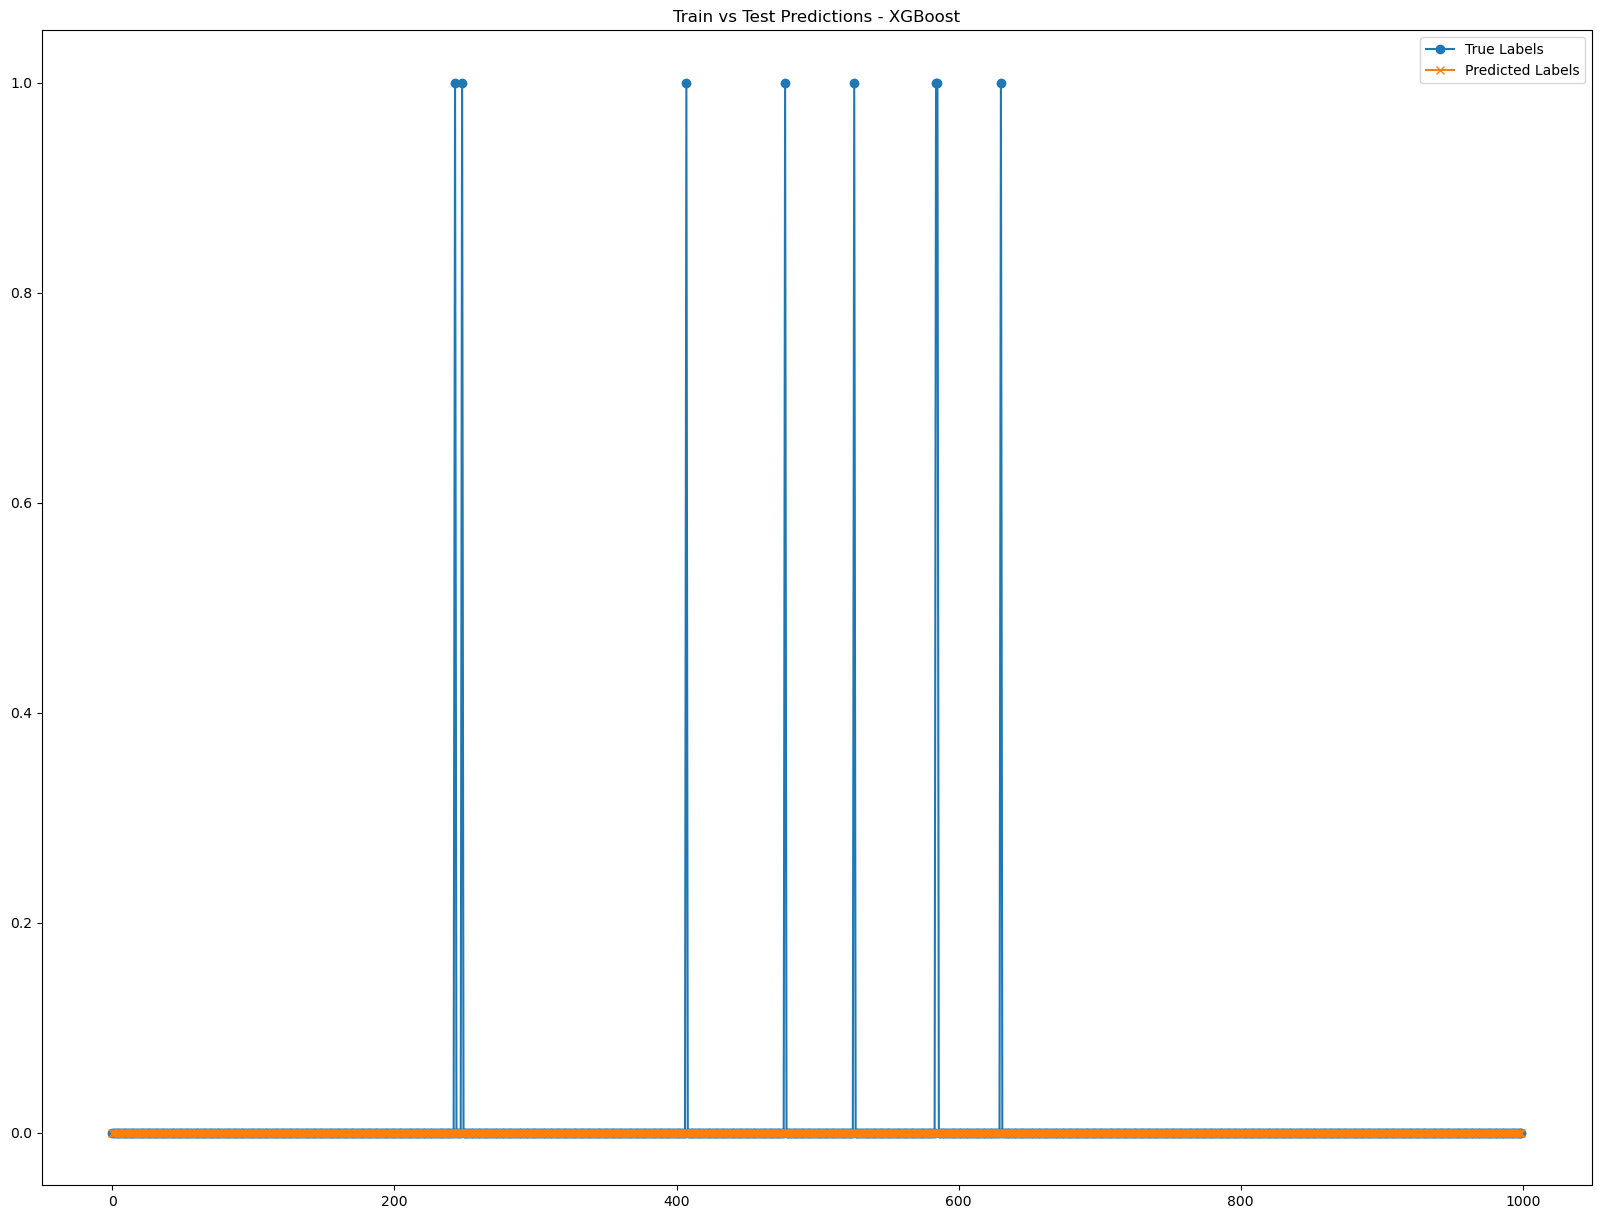

In [79]:
#test vs train graph
plt.figure(figsize=(20, 15))
plt.plot(y_test.values[:1000], label="True Labels", marker='o')
plt.plot(y_pred[:1000], label="Predicted Labels", marker='x')
plt.title(f"Train vs Test Predictions - {best_model_name}")
plt.legend()
plt.show()